```
Copyright 2021 IBM Corporation

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

## Batched Tree Ensembles on Credit Card Fraud Dataset

## Background 

The goal of this competition is to predict if a credit card transaction is fraudulent or genuine based on a set of anonymized features.

## Source

The raw dataset can be obtained directly from [Kaggle: Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In this example, we download the dataset directly from Kaggle using their API. In order for it to work, you must: login into Kaggle and folow [these instructions](https://www.kaggle.com/docs/api) to install your API token on your machine.

## Goal
The goal of this notebook is to illustrate how Snap ML can be used for incremental learning of an XGBoost classifier via the `BatchedTreeEnsemble` feature.

## Code

In [1]:
cd ../

/Users/tpa/Code/snapml-examples/examples


In [2]:
CACHE_DIR='cache-dir'

In [3]:
from datasets import CreditCardFraud
import os
import pandas as pd
from zipfile import ZipFile
import io
import numpy as np
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from snapml import BatchedTreeEnsembleClassifier

When run for the first time, the cell below will download the raw data from Kaggle. On subsequent runs, it will used the cached file.

In [4]:
dataset = CreditCardFraud(cache_dir=CACHE_DIR)
if not os.path.isfile(dataset.raw_file):
    dataset.download_raw_data()

The cell below perform a first pass through the dataset. Data is processed batch-by-batch. For each batch, we perform a train/validation/test split. The indices for the training examples within each batch are stored for the second pass (in which training will be performed). The validation and test indices are used to create a validation and test `DataFrame` which contain data sampled from each batch. This is recommended so that the validation and test set accurately reflect the global statistics of the dataset. 

In [5]:
batchsize = 20_000

test_frac = 0.1
val_frac = 0.1

df_val = None
df_test = None
train_indices = []

with ZipFile(dataset.raw_file, 'r') as f:
    
    file = io.BytesIO(f.read('creditcard.csv'))
    
    with pd.read_csv(file, chunksize=batchsize) as reader:
        for idx, batch in enumerate(reader):
            
            ind = np.arange(batch.shape[0])
            
            np.random.seed(idx)
            np.random.shuffle(ind)
            
            ind_train, ind_val, ind_test = np.split(
                ind, 
                [int((1.0-val_frac-test_frac)*len(ind)), int((1.0-test_frac)*len(ind))]
            )
            
            train_indices.append(ind_train)
            
            if idx == 0:
                df_val = batch.iloc[ind_val]
                df_test = batch.iloc[ind_test]
            else:
                df_val = pd.concat([df_val, batch.iloc[ind_val]])
                df_test = pd.concat([df_test, batch.iloc[ind_test]])

In the cell below we evaluate the baseline: training an `XGBClassifier` which learns 100 trees of depth 6 from the first batch of data only.

In [6]:
with ZipFile(dataset.raw_file, 'r') as f:
    file = io.BytesIO(f.read('creditcard.csv'))
    df = pd.read_csv(file, nrows=batchsize)
    
df_train = df.iloc[train_indices[0]]
    
y_train, X_train = df_train.pop("Class").values, df_train.values

clf = XGBClassifier(n_estimators=100, max_depth=6)
clf.fit(X_train, y_train)

y_val, X_val = df_val.pop("Class").values, df_val.values
y_test, X_test = df_test.pop("Class").values, df_test.values

f1_val_baseline = f1_score(y_val, clf.predict(X_val))
f1_test_baseline = f1_score(y_test, clf.predict(X_test))
    
print("[xgboost, batches= %2d] F1 Score: %.4f (Validation), %.4f (Test)" % (1, f1_val_baseline, f1_test_baseline))

[xgboost, batches=  1] F1 Score: 0.7368 (Validation), 0.6591 (Test)


![Incremental Learning Architecture](architecture.png)

In the cell below we perform a second pass through the full dataset to perform incremental learning. 

Firstly, we create a `BatchedTreeEnsembleClassifier` with the `base_ensemble` set to the same `XGBClassifier` that was used for the baseline. 

Additionally, we set the `max_sub_ensembles` parameter to be equal to the total number of batches. 

We then iterate through the batches one-by-one, and call the `partial_fit` function which learns a new sub-ensemble from the new batch of data. Each sub-ensemble comprises a small set of trees and these trees are trained to correct the errors from all previous sub-ensembles, leading to gradual improvement in accuracy. This concept is illustrated in the Figure above.

At the end of training, the `BatchedTreeEnsemble` has built an ensemble comprising a sub-ensemble for each batch. The total number of trees in the ensemble will not exceed the number of trees in the baseline, but these trees has been trained with more information. 

In [7]:
n_batches = len(train_indices)

result = pd.DataFrame(columns=["f1_val", "f1_test"])

with ZipFile(dataset.raw_file, 'r') as f:
    
    file = io.BytesIO(f.read('creditcard.csv'))
    
    clf = BatchedTreeEnsembleClassifier(
        base_ensemble=XGBClassifier(n_estimators=100, max_depth=6),
        max_sub_ensembles=n_batches,
    )
    
    with pd.read_csv(file, chunksize=batchsize) as reader:
        for idx, chunk in enumerate(reader):
            
            df_train = chunk.iloc[train_indices[idx]]
            y_train = df_train.pop("Class").values
            X_train = df_train.values
           
            clf.partial_fit(X_train, y_train, classes=[0,1])
            
            result.loc[idx, "f1_val"] = f1_score(y_val, clf.predict(X_val))
            result.loc[idx, "f1_test"] = f1_score(y_test, clf.predict(X_test))
            
            print("[snapml, batches=%2d] F1 Score: %.4f (Validation), %.4f (Test)" 
                  % (1+idx, result.loc[idx, "f1_val"], result.loc[idx, "f1_test"]))

[snapml, batches= 1] F1 Score: 0.6667 (Validation), 0.6504 (Test)
[snapml, batches= 2] F1 Score: 0.7273 (Validation), 0.7207 (Test)
[snapml, batches= 3] F1 Score: 0.7527 (Validation), 0.7429 (Test)
[snapml, batches= 4] F1 Score: 0.7609 (Validation), 0.7500 (Test)
[snapml, batches= 5] F1 Score: 0.7778 (Validation), 0.7500 (Test)
[snapml, batches= 6] F1 Score: 0.7865 (Validation), 0.7500 (Test)
[snapml, batches= 7] F1 Score: 0.7955 (Validation), 0.7647 (Test)
[snapml, batches= 8] F1 Score: 0.7955 (Validation), 0.7600 (Test)
[snapml, batches= 9] F1 Score: 0.8000 (Validation), 0.7789 (Test)
[snapml, batches=10] F1 Score: 0.8193 (Validation), 0.7872 (Test)
[snapml, batches=11] F1 Score: 0.8193 (Validation), 0.7957 (Test)
[snapml, batches=12] F1 Score: 0.8193 (Validation), 0.8000 (Test)
[snapml, batches=13] F1 Score: 0.8193 (Validation), 0.8125 (Test)
[snapml, batches=14] F1 Score: 0.8193 (Validation), 0.8125 (Test)
[snapml, batches=15] F1 Score: 0.8193 (Validation), 0.8125 (Test)


To verify that the inference complexity does not exceed the baseline, we can iterate through the sub-ensembles that are trained on each batch and inspect the number of trees. We can see that the incremental algorithm learns 6 trees from each batch of data, and the total number of trees is actually a little less than the baseline (due to rounding effects):

In [8]:
trees = []
for ensemble in clf.ensembles_:
    trees.append(ensemble.get_params()['n_estimators'])
print("Trees learned from each batch:", trees)
print("Total trees in ensemble:      ", np.sum(trees))


Trees learned from each batch: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Total trees in ensemble:       90


Finally, in the cell below we plot the evolution of the validation and test score as the incremental learning progresses and compare to the baseline. 

(0.6, 0.85)

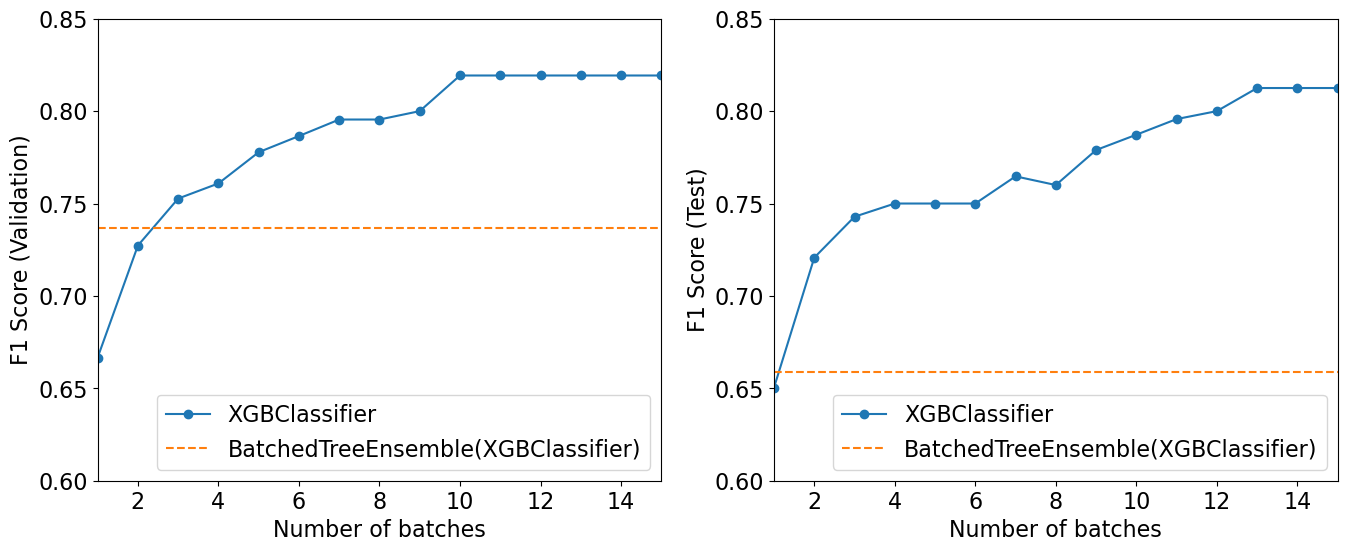

In [9]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(1+result.index, result['f1_val'],'-o')
ax[0].plot(1+result.index, np.ones_like(result.index)*f1_val_baseline, '--')
ax[0].set_xlabel("Number of batches")
ax[0].set_ylabel("F1 Score (Validation)")
ax[0].legend(["XGBClassifier", "BatchedTreeEnsemble(XGBClassifier)"], loc='lower right')
ax[0].set_xlim([1, n_batches])
ax[0].set_ylim([0.6, 0.85])

ax[1].plot(1+result.index, result['f1_test'],'-o')
ax[1].plot(1+result.index, np.ones_like(result.index)*f1_test_baseline, '--')
ax[1].set_xlabel("Number of batches")
ax[1].set_ylabel("F1 Score (Test)")
ax[1].legend(["XGBClassifier", "BatchedTreeEnsemble(XGBClassifier)"], loc='lower right')
ax[1].set_xlim([1, n_batches])
ax[1].set_ylim([0.6, 0.85])

We notice that for the first few batches, the `BatchedTreeEnsemble` may perform slightly worse than the baseline (this is expected behaviour), however as more batches are consumed the model that has seen more data can signficantly outperform the baseline both in terms of validation score and test score. 